In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
import torch
import torchvision
import torch.nn as nn
                                                  #  '''  do not forget =    it's (HEIGHT, WIDTH)    ''' 
import torch.nn.functional as F
import torch.optim as optim
torch.set_printoptions(linewidth = 120)
torch.set_grad_enabled(True)
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader


import matplotlib.pyplot as plt

import numpy as np
   
np.set_printoptions(threshold=50)    # 50 lines 


from PIL import Image 

import os

from IPython.display import clear_output
from torchvision.transforms import ToTensor

from numpy import random 

from scipy.ndimage.filters import gaussian_filter1d   ## smoother

In [0]:



arr = np.array(np.load("/content/drive/My Drive/kaggle/doggonet/numpy_new_big.npy", allow_pickle = True))
np.random.shuffle(arr)




In [0]:


def extract_column(arr, index):
  
  x_train = []
  for m in range (len(arr)):
  
    x_train.append(arr[m][index])
    
  return( np.array(x_train))
    
  
x_train = extract_column(arr,0)

y_train = extract_column(arr,1)
  
  

In [5]:


x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()



train_data = TensorDataset(x_train_tensor, y_train_tensor)       ## make compatible with DataLoader 
print(train_data[0])



(tensor([[[108., 104., 101.,  ...,  80.,  77.,  80.],
         [102., 107., 100.,  ...,  82.,  81.,  82.],
         [ 92., 111.,  99.,  ...,  75.,  79.,  83.],
         ...,
         [198., 193., 187.,  ..., 189., 193., 193.],
         [194., 189., 188.,  ..., 195., 194., 194.],
         [190., 192., 191.,  ..., 193., 196., 196.]],

        [[130., 131., 132.,  ...,  32.,  28.,  28.],
         [122., 131., 129.,  ...,  33.,  28.,  25.],
         [108., 132., 126.,  ...,  31.,  28.,  28.],
         ...,
         [193., 189., 185.,  ..., 181., 182., 180.],
         [189., 184., 185.,  ..., 186., 182., 180.],
         [185., 187., 189.,  ..., 184., 184., 183.]],

        [[129., 132., 136.,  ...,  40.,  37.,  38.],
         [119., 131., 133.,  ...,  39.,  36.,  34.],
         [105., 131., 129.,  ...,  31.,  31.,  32.],
         ...,
         [171., 167., 164.,  ..., 166., 166., 164.],
         [167., 163., 165.,  ..., 171., 167., 164.],
         [163., 166., 168.,  ..., 170., 169., 167.]]

In [0]:
## using a dataloader 

train_loader = DataLoader(dataset=train_data, batch_size=102, shuffle=True)




# next(iter(train_loader))  # view a sample batch

In [0]:
def generate_batched_np_array(np_arr, batch_size):

  batched_arr = []

  for index in range(0,np_arr.shape[0],batch_size):

      batch=data[index:min(index+batch_size,data.shape[0]),:]

      batched_arr.append(batch)

  batched_arr = np.array(batched_arr)
  
  return batched_arr


def generate_tensor(image_arr):
  doo = torch.tensor(image_arr).unsqueeze(0)
  
  doo = doo.float()
  
  return doo


## test NN output

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()



def vis_op(image_tensor):
    doo = image_tensor

    res = doggonet(doo).squeeze(0)
    
    print("prediction = ", res.argmax().item())
    pl = (res.tolist())
    
    pl = softmax(pl)
    

    plt.plot(pl)
    plt.ylabel('some numbers')
    plt.show()
    


def vis_loss(loss_arr):
  
  plt.plot(loss_arr)
  plt.show()


In [8]:


## doggonet 


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        
        
        self.conv1 = nn.Conv2d(3, 12, 5)
        
        # in_channels = 1, out_channels = 10 kernel_size = 5 (kernel is the filter thingy )
        
        self.pool = nn.MaxPool2d(5, 5)
        
        self.conv2 = nn.Conv2d(12, 36, 5)
        
        self.fc1 = nn.Linear(1764, 900)       # linear starts 
        self.fc2 = nn.Linear(900, 300)
        self.fc3 = nn.Linear(300, 120)   ## op

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))        
    
        
        x = x.view(-1, 1764)                   # reshape -- changed from 180 to 80 
        
        x = F.relu(self.fc1(x))  
        

        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        return x

doggonet = Net()

print(doggonet)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 36, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1764, out_features=900, bias=True)
  (fc2): Linear(in_features=900, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=120, bias=True)
)


In [0]:

def make_train_step(model, optimizer):
  
  
  
    def train_step(x, y):
      
        model.train()
        
        pred = model(x)
        
        
        y = y.long()
        
        loss = F.cross_entropy(pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        optimizer.zero_grad()
        
        print ("|", end = "")
        
        return loss.item()
      
    return train_step



In [0]:
model = doggonet
 
optimizer = optim.Adam(doggonet.parameters(), lr = 0.001)

train_step = make_train_step(model, optimizer)


losses = []




def train_one_epoch(train_loader, epochs):
  

  for i in range(epochs):
#     print ("                    |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print ("                    |                                                                                                   |")

    print("training batches  --", end = "")
   
    for x_batch, y_batch in train_loader:
      
      
      
      loss = train_step(x_batch, y_batch)
        
      losses.append(loss)
      
    
    batch_avg_loss = sum(losses[-102:])/102  # compute avg loss
    print ("")
    
    print("batch avg loss = ", batch_avg_loss)
      
    vis_loss(losses)

        
    
    
    
    
    
    
    
    
  print ("epoch complete -------------------------------------------")
    
    
    
    

                    |                                                                                                   |
training batches  --|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
batch avg loss =  4.356480495602477


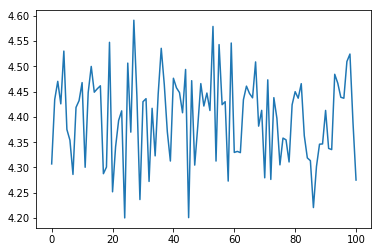

                    |                                                                                                   |
training batches  --|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
batch avg loss =  3.921096259472417


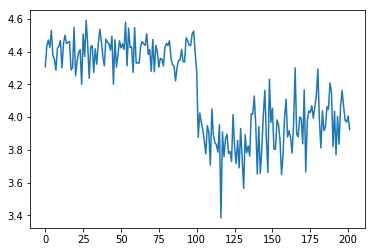

                    |                                                                                                   |
training batches  --|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
batch avg loss =  3.1343332973181033


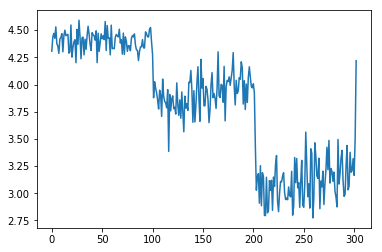

                    |                                                                                                   |
training batches  --|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
batch avg loss =  2.1928654803949246


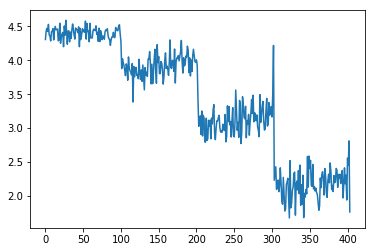

                    |                                                                                                   |
training batches  --|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
batch avg loss =  1.499978787174412


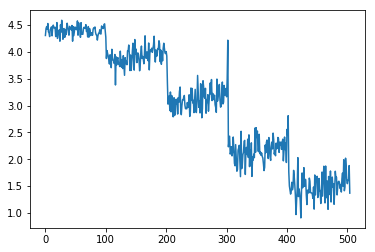

                    |                                                                                                   |
training batches  --|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
batch avg loss =  1.1207692114745869


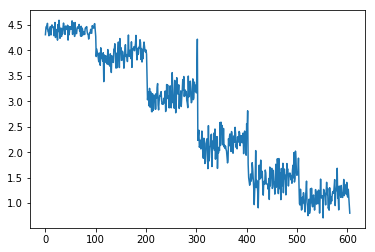

                    |                                                                                                   |
training batches  --|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
batch avg loss =  0.8991805741599962


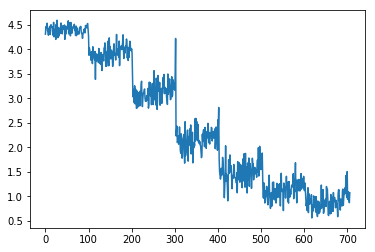

                    |                                                                                                   |
training batches  --|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
batch avg loss =  0.7392925433084077


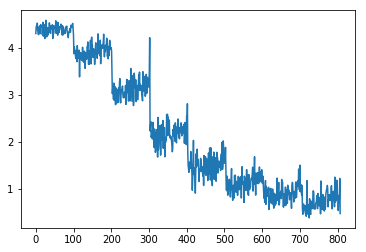

                    |                                                                                                   |
training batches  --|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
batch avg loss =  0.5989699449901488


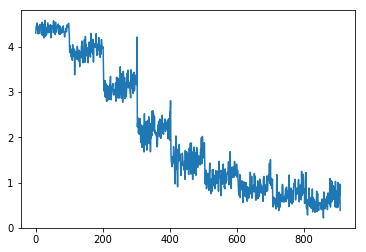

                    |                                                                                                   |
training batches  --|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
batch avg loss =  0.5151800409543748


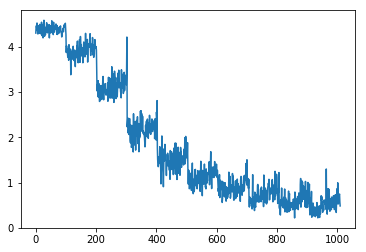

epoch complete -------------------------------------------


In [18]:
train_one_epoch(train_loader, 10)        

original label --  60
prediction =  60


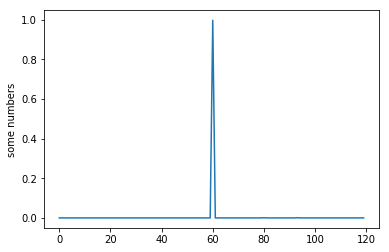

In [25]:
# test the trained NN

sample_image = arr[10][0]

print("original label -- ", arr[10][1])

img = generate_tensor(sample_image)

vis_op(img)

In [26]:
nn_name = "/content/drive/My Drive/kaggle/doggonet/models/" + "ten_epochs_doggonet_batchwise.pth"

torch.save(doggonet, nn_name)


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MaxPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
